FER Model Testing & Evaluation

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

2025-10-14 14:48:29.880829: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-14 14:48:30.284023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 14:48:32.849533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


CONFIGURATION

In [7]:
DATA_DIR = "../../../Data/images"
TEST_DIR = os.path.join(DATA_DIR, "validation")
MODEL_DIR = "../../../models"

# Change this based on which model you want to test
MODEL_TAG_1 = "mini_xception_fer_pretrained_best"
MODEL_TAG_2 = "mini_xception_fer_pretrained"  

MODEL_PATH = os.path.join(MODEL_DIR, f"{MODEL_TAG_1}.keras")
CLASSMAP_PATH = os.path.join(MODEL_DIR, f"{MODEL_TAG_2}_classes.json")
HISTORY_PATH = os.path.join(MODEL_DIR, f"{MODEL_TAG_2}_history.json")

IMG_SIZE = 48
BATCH_SIZE = 32

print("=" * 60)
print("FER MODEL TESTING")
print("=" * 60)
print(f"Test directory: {TEST_DIR}")
print(f"Model tag: {MODEL_TAG_1}")
print()

FER MODEL TESTING
Test directory: ../../../Data/images/validation
Model tag: mini_xception_fer_pretrained_best



LOAD MODEL & CLASS MAPPING

In [8]:
print("Loading model...")

# Check if model exists
if not os.path.exists(MODEL_PATH):
    print(f" Model file not found: {MODEL_PATH}")
    print(f"\nAvailable model files in {MODEL_DIR}:")
    if os.path.exists(MODEL_DIR):
        for f in sorted(os.listdir(MODEL_DIR)):
            if f.endswith(('.h5', '.keras')):
                print(f"  - {f}")
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

try:
    model = keras.models.load_model(MODEL_PATH)
    print("✓ Model loaded successfully!")
    print(f"  Path: {MODEL_PATH}")
except Exception as e:
    print(f" Error loading model: {e}")
    raise

# Load class mapping
print("\nLoading class mapping...")
if not os.path.exists(CLASSMAP_PATH):
    raise FileNotFoundError(f"Class mapping not found: {CLASSMAP_PATH}")

with open(CLASSMAP_PATH, "r") as f:
    class_map = json.load(f)

# Create ordered list of class names
idx_to_class = {v: k for k, v in class_map.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(f"✓ Classes loaded: {class_names}")

# Check if model was trained with transfer learning
is_transfer_learning = False
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, "r") as f:
        hist_data = json.load(f)
        is_transfer_learning = hist_data.get("used_pretrained", False)
        if is_transfer_learning:
            print(" This model uses Transfer Learning!")

print()

Loading model...
✓ Model loaded successfully!
  Path: ../../../models/mini_xception_fer_pretrained_best.keras

Loading class mapping...
✓ Classes loaded: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 This model uses Transfer Learning!



CREATE TEST DATA GENERATOR

In [9]:
print("Creating test data generator...")
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

print(f"✓ Test samples: {test_generator.samples}")
print(f"✓ Number of classes: {test_generator.num_classes}")
print()

Creating test data generator...
Found 7066 images belonging to 7 classes.
✓ Test samples: 7066
✓ Number of classes: 7



EVALUATE MODEL

In [10]:
print("Evaluating model on test set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print("=" * 60)
print("TEST RESULTS")
print("=" * 60)
print(f"Test Loss:     {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.6f} ({test_acc*100:.2f}%)")
print("=" * 60)
print()

Evaluating model on test set...


/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TEST RESULTS
Test Loss:     1.136238
Test Accuracy: 0.574583 (57.46%)



GENERATE PREDICTIONS

In [11]:
print("Generating predictions...")
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print(f"✓ Predictions generated: {len(y_pred)}")
print()

Generating predictions...
✓ Predictions generated: 7066



CLASSIFICATION REPORT

In [12]:
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print()

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.4231    0.5104    0.4627       960
     disgust     1.0000    0.0090    0.0179       111
        fear     0.4451    0.2112    0.2865      1018
       happy     0.7593    0.8400    0.7976      1825
     neutral     0.4821    0.6661    0.5594      1216
         sad     0.4889    0.3854    0.4310      1139
    surprise     0.6917    0.7177    0.7044       797

    accuracy                         0.5746      7066
   macro avg     0.6129    0.4771    0.4656      7066
weighted avg     0.5732    0.5746    0.5556      7066




CONFUSION MATRIX

Generating confusion matrix...


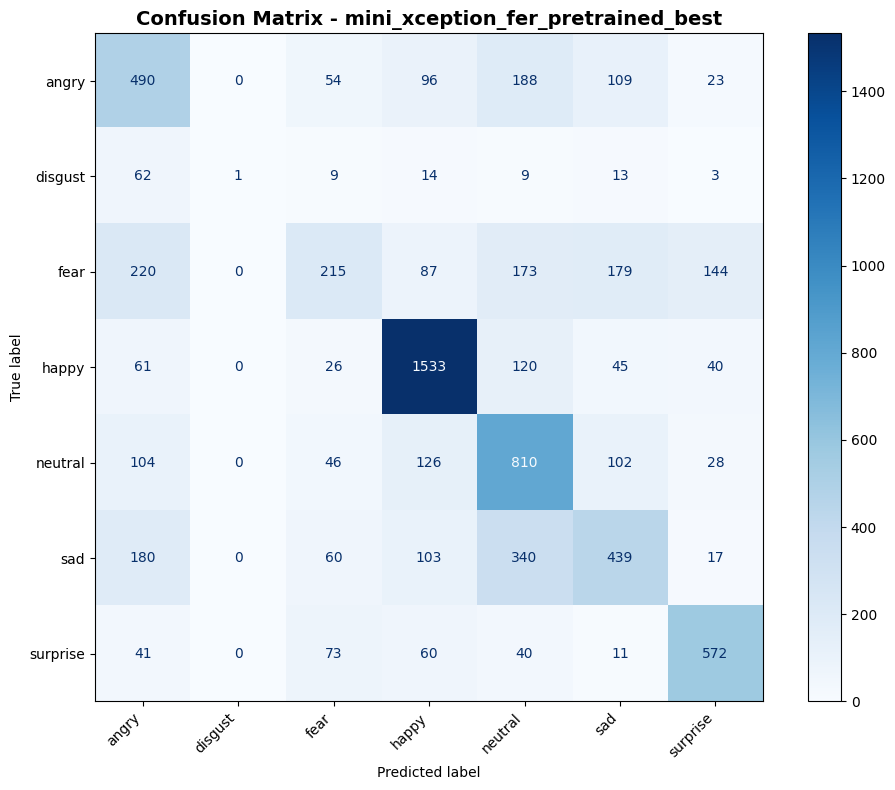

In [13]:
print("Generating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format='d')
plt.title(f"Confusion Matrix - {MODEL_TAG_1}", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

PER-CLASS ACCURACY


Calculating per-class accuracy...
------------------------------------------------------------
angry       : 0.5104 (51.04%)
disgust     : 0.0090 (0.90%)
fear        : 0.2112 (21.12%)
happy       : 0.8400 (84.00%)
neutral     : 0.6661 (66.61%)
sad         : 0.3854 (38.54%)
surprise    : 0.7177 (71.77%)
------------------------------------------------------------



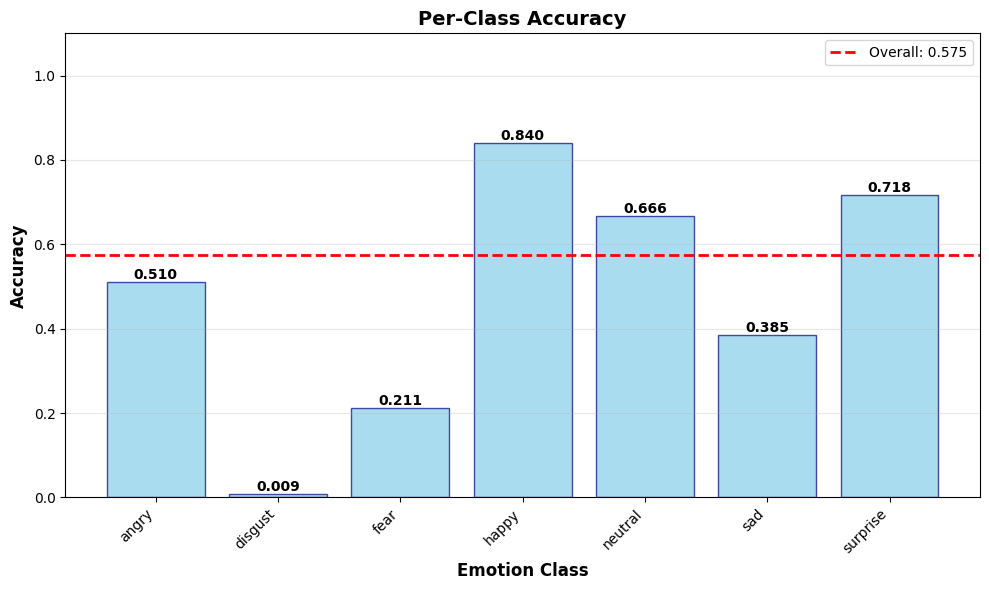

In [14]:
print("\nCalculating per-class accuracy...")
class_accuracies = []

print("-" * 60)
for i, class_name in enumerate(class_names):
    class_mask = (y_true == i)
    if class_mask.sum() > 0:
        class_acc = (y_pred[class_mask] == y_true[class_mask]).mean()
        class_accuracies.append(class_acc)
        print(f"{class_name:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)")
    else:
        class_accuracies.append(0)
        print(f"{class_name:12s}: No samples")
print("-" * 60)
print()

# Plot per-class accuracy
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_names, class_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim(0, 1.1)
ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax.set_xlabel("Emotion Class", fontsize=12, fontweight='bold')
ax.set_title("Per-Class Accuracy", fontsize=14, fontweight='bold')
ax.axhline(y=test_acc, color='r', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.3f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SAMPLE DISTRIBUTION

Test Set Distribution:
------------------------------------------------------------
angry       :  960 samples (13.6%)
disgust     :  111 samples (1.6%)
fear        : 1018 samples (14.4%)
happy       : 1825 samples (25.8%)
neutral     : 1216 samples (17.2%)
sad         : 1139 samples (16.1%)
surprise    :  797 samples (11.3%)
------------------------------------------------------------
Total       : 7066 samples



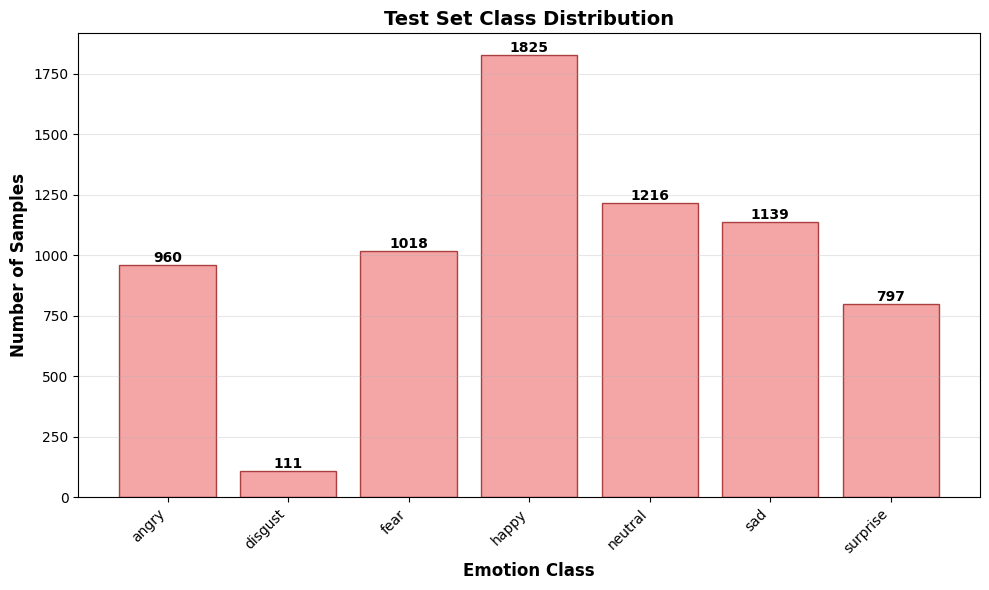

In [15]:
class_distribution = Counter(y_true)

print("Test Set Distribution:")
print("-" * 60)
for i, class_name in enumerate(class_names):
    count = class_distribution[i]
    percentage = (count / len(y_true)) * 100
    print(f"{class_name:12s}: {count:4d} samples ({percentage:.1f}%)")

print("-" * 60)
print(f"{'Total':12s}: {len(y_true):4d} samples")
print()

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 6))
counts = [class_distribution[i] for i in range(len(class_names))]
bars = ax.bar(class_names, counts, color='lightcoral', edgecolor='darkred', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_xlabel("Emotion Class", fontsize=12, fontweight='bold')
ax.set_title("Test Set Class Distribution", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TOP MISCLASSIFICATIONS

In [16]:
print("\nTop 5 Misclassifications:")
print("-" * 60)

misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i, j]))

misclassifications.sort(key=lambda x: x[2], reverse=True)

for idx, (true_label, pred_label, count) in enumerate(misclassifications[:5], 1):
    print(f"{idx}. {true_label} → {pred_label}: {count} times")

print("-" * 60)
print()


Top 5 Misclassifications:
------------------------------------------------------------
1. sad → neutral: 340 times
2. fear → angry: 220 times
3. angry → neutral: 188 times
4. sad → angry: 180 times
5. fear → sad: 179 times
------------------------------------------------------------



PREDICTION CONFIDENCE ANALYSIS

Prediction Confidence Analysis:
------------------------------------------------------------
Correct predictions:   Avg confidence = 0.6690
Incorrect predictions: Avg confidence = 0.4584
------------------------------------------------------------



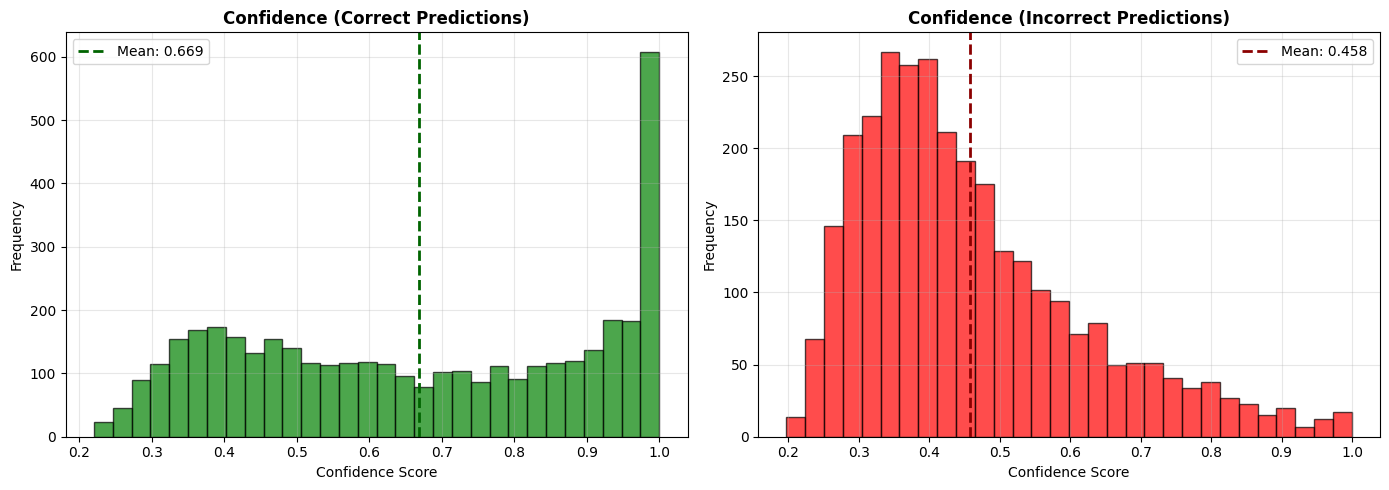

In [17]:
print("Prediction Confidence Analysis:")
print("-" * 60)

# Max probabilities for each prediction
max_probs = np.max(y_pred_probs, axis=1)

correct_mask = (y_pred == y_true)
correct_confidences = max_probs[correct_mask]
incorrect_confidences = max_probs[~correct_mask]

print(f"Correct predictions:   Avg confidence = {correct_confidences.mean():.4f}")
print(f"Incorrect predictions: Avg confidence = {incorrect_confidences.mean():.4f}")
print("-" * 60)
print()

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(correct_confidences, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title("Confidence (Correct Predictions)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Confidence Score")
axes[0].set_ylabel("Frequency")
axes[0].axvline(correct_confidences.mean(), color='darkgreen', linestyle='--', 
                linewidth=2, label=f'Mean: {correct_confidences.mean():.3f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(incorrect_confidences, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title("Confidence (Incorrect Predictions)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Confidence Score")
axes[1].set_ylabel("Frequency")
axes[1].axvline(incorrect_confidences.mean(), color='darkred', linestyle='--', 
                linewidth=2, label=f'Mean: {incorrect_confidences.mean():.3f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

COMPARISON WITH TRAINING HISTORY


Loading training history...


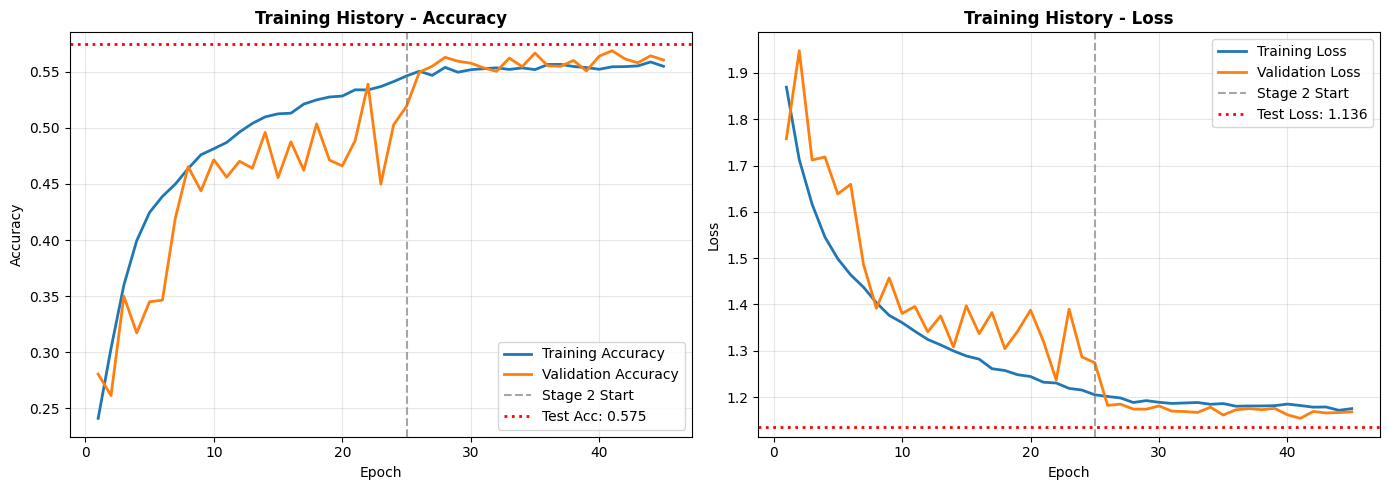


TRAINING HISTORY SUMMARY
Best Validation Accuracy:  0.5689 (Epoch 41)
Final Validation Accuracy: 0.5606
Test Accuracy:             0.5746
Difference (Test vs Best): +0.0056


In [18]:
if os.path.exists(HISTORY_PATH):
    print("\nLoading training history...")
    with open(HISTORY_PATH, "r") as f:
        history = json.load(f)
    
    # Extract data
    stage1_epochs = len(history['stage1']['accuracy'])
    stage2_epochs = len(history['stage2']['accuracy'])
    
    all_epochs = list(range(1, stage1_epochs + stage2_epochs + 1))
    all_train_acc = history['stage1']['accuracy'] + history['stage2']['accuracy']
    all_val_acc = history['stage1']['val_accuracy'] + history['stage2']['val_accuracy']
    all_train_loss = history['stage1']['loss'] + history['stage2']['loss']
    all_val_loss = history['stage1']['val_loss'] + history['stage2']['val_loss']
    
    best_val_acc = max(all_val_acc)
    best_epoch = all_val_acc.index(best_val_acc) + 1
    final_val_acc = all_val_acc[-1]
    
    # Plot combined training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(all_epochs, all_train_acc, label="Training Accuracy", linewidth=2)
    axes[0].plot(all_epochs, all_val_acc, label="Validation Accuracy", linewidth=2)
    axes[0].axvline(x=stage1_epochs, color="gray", linestyle="--", alpha=0.7, label="Stage 2 Start")
    axes[0].axhline(y=test_acc, color="red", linestyle=":", linewidth=2, label=f"Test Acc: {test_acc:.3f}")
    axes[0].set_title("Training History - Accuracy", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(all_epochs, all_train_loss, label="Training Loss", linewidth=2)
    axes[1].plot(all_epochs, all_val_loss, label="Validation Loss", linewidth=2)
    axes[1].axvline(x=stage1_epochs, color="gray", linestyle="--", alpha=0.7, label="Stage 2 Start")
    axes[1].axhline(y=test_loss, color="red", linestyle=":", linewidth=2, label=f"Test Loss: {test_loss:.3f}")
    axes[1].set_title("Training History - Loss", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)
    print("TRAINING HISTORY SUMMARY")
    print("=" * 60)
    print(f"Best Validation Accuracy:  {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Test Accuracy:             {test_acc:.4f}")
    print(f"Difference (Test vs Best): {test_acc - best_val_acc:+.4f}")
    print("=" * 60)

FINAL SUMMARY

In [19]:
print("\n" + "=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)
print(f"Model:           {MODEL_TAG_1}")
if is_transfer_learning:
    print(f"Training Method: Transfer Learning ")
else:
    print(f"Training Method: From Scratch")
print(f"Test Samples:    {len(y_true)}")
print(f"Test Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:       {test_loss:.6f}")
print(f"Best Class:      {class_names[np.argmax(class_accuracies)]} ({max(class_accuracies):.4f})")
print(f"Worst Class:     {class_names[np.argmin(class_accuracies)]} ({min(class_accuracies):.4f})")
print("=" * 60)
print("\n✓ Evaluation complete!")


EVALUATION SUMMARY
Model:           mini_xception_fer_pretrained_best
Training Method: Transfer Learning 
Test Samples:    7066
Test Accuracy:   0.5746 (57.46%)
Test Loss:       1.136238
Best Class:      happy (0.8400)
Worst Class:     disgust (0.0090)

✓ Evaluation complete!
